В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import time

# Завантажуємо дані
raw_df = pd.read_csv("drive/MyDrive/Colab Notebooks/train.csv")

# Видаляємо технічні колонки
raw_df = raw_df.drop(columns=["id", "CustomerId", "Surname"], errors="ignore")


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [4]:
input_cols = [c for c in raw_df.columns if c != "Exited"]

train_df, val_df = split_train_val(raw_df, target_col="Exited")

train_inputs, train_targets = separate_inputs_targets(train_df, input_cols, target_col="Exited")
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols, target_col="Exited")

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [5]:
for col in train_inputs.select_dtypes(include="object").columns:
    train_inputs[col] = train_inputs[col].astype("category")
    val_inputs[col] = val_inputs[col].astype("category")

print("Train shape:", train_inputs.shape, "Validation shape:", val_inputs.shape)
print("Категоріальні ознаки:", train_inputs.select_dtypes(include="category").columns.tolist())

Train shape: (12000, 10) Validation shape: (3000, 10)
Категоріальні ознаки: ['Geography', 'Gender']


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [7]:
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",  # пришвидшує
    use_label_encoder=False,
    eval_metric="auc",
    enable_categorical=True
)
xgb_clf.fit(train_inputs, train_targets)

train_preds = xgb_clf.predict_proba(train_inputs)[:,1]
val_preds = xgb_clf.predict_proba(val_inputs)[:,1]

print("Train AUROC:", roc_auc_score(train_targets, train_preds))
print("Validation AUROC:", roc_auc_score(val_targets, val_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:49:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train AUROC: 0.9613667982312049
Validation AUROC: 0.9338102750531586


**Базова модель XGBoost показала високу якість, що перевищує результат дерев рішень. Різниця між тренувальною та валідаційною вибірками невелика, отже, модель добре узагальнює й не страждає від суттєвого overfitting, має низький bias і низький variance, і вже на базових налаштуваннях перевершує Decision Tree.**

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [9]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 400, 50, dtype=int)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.choice('min_child_weight', [1, 3, 5, 7])
}

# Objective функція

def objective(params):
    clf = XGBClassifier(
        **params,
        tree_method="hist",
        enable_categorical=True,
        missing=np.nan,
        eval_metric="auc",
        use_label_encoder=False,
        random_state=42
    )
    clf.fit(train_inputs, train_targets)
    val_preds = clf.predict_proba(val_inputs)[:, 1]
    auc = roc_auc_score(val_targets, val_preds)
    return {'loss': -auc, 'status': STATUS_OK}

# Запуск Hyperopt

trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Найкращі гіперпараметри:", best_params)

# Відновлюємо справжні значення hp.choice

n_estimators_choices = list(np.arange(100, 400, 50, dtype=int))
max_depth_choices = list(np.arange(3, 10, dtype=int))
min_child_weight_choices = [1, 3, 5, 7]

final_clf = XGBClassifier(
    max_depth=max_depth_choices[best_params['max_depth']],
    learning_rate=best_params['learning_rate'],
    n_estimators=n_estimators_choices[best_params['n_estimators']],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    min_child_weight=min_child_weight_choices[best_params['min_child_weight']],
    tree_method="hist",
    enable_categorical=True,
    missing=np.nan,
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)

# Навчання фінальної моделі

final_clf.fit(train_inputs, train_targets)

train_preds = final_clf.predict_proba(train_inputs)[:, 1]
val_preds = final_clf.predict_proba(val_inputs)[:, 1]

print("Train AUROC:", roc_auc_score(train_targets, train_preds))
print("Validation AUROC:", roc_auc_score(val_targets, val_preds))

  5%|▌         | 1/20 [00:00<00:02,  6.98trial/s, best loss: -0.936366691816997]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 15%|█▌        | 3/20 [00:00<00:03,  4.69trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 20%|██        | 4/20 [00:00<00:03,  4.79trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 30%|███       | 6/20 [00:01<00:02,  5.42trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 45%|████▌     | 9/20 [00:01<00:01,  6.11trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 55%|█████▌    | 11/20 [00:01<00:01,  5.92trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 65%|██████▌   | 13/20 [00:02<00:01,  5.64trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 75%|███████▌  | 15/20 [00:02<00:00,  6.45trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 80%|████████  | 16/20 [00:02<00:00,  6.52trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 85%|████████▌ | 17/20 [00:03<00:00,  5.61trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 95%|█████████▌| 19/20 [00:03<00:00,  4.83trial/s, best loss: -0.9372144865903012]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



100%|██████████| 20/20 [00:03<00:00,  5.25trial/s, best loss: -0.9372144865903012]
Найкращі гіперпараметри: {'colsample_bytree': np.float64(0.9293728051431607), 'gamma': np.float64(2.86364059503943), 'learning_rate': np.float64(0.05558211316295016), 'max_depth': np.int64(1), 'min_child_weight': np.int64(0), 'n_estimators': np.int64(1), 'subsample': np.float64(0.658785114914011)}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train AUROC: 0.9464862054315915
Validation AUROC: 0.9372144865903012


**Оптимізація XGBoost за допомогою Hyperopt дозволила підвищити якість моделі. Різниця між Train та Validation невелика, що свідчить про добрий баланс bias та variance і відсутність суттєвого overfitting.**

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [18]:
categorical_features = [
    col for col in train_inputs.columns if train_inputs[col].dtype.name == "category"
]
cat_feature_indexes = [
    train_inputs.columns.get_loc(col) for col in categorical_features
]

# Створюємо і навчаємо модель LightGBM

lgb_clf = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,             # без обмеження глибини
    subsample=0.8,            # частка даних для одного дерева
    colsample_bytree=0.8,     # частка ознак для одного дерева
    random_state=42
)

lgb_clf.fit(
    train_inputs,
    train_targets,
    eval_set=[(val_inputs, val_targets)],
    eval_metric="auc",
    categorical_feature=cat_feature_indexes
)

# Оцінка якості

train_preds = lgb_clf.predict_proba(train_inputs)[:, 1]
val_preds = lgb_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print("Train AUROC:", train_auc)
print("Validation AUROC:", val_auc)


[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
Train AUROC: 0.9905229017752557
Validation AUROC: 0.9292523492694972


**Базова модель LightGBM показала доволі високу якість, проте поступається оптимізованому XGBoost. Train AUROC значно вищий, ніж на валідації, що свідчить про наявність певного overfitting і високий variance.**

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [19]:
space_lgb = {
    'num_leaves': hp.choice('num_leaves', np.arange(20, 150, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 12, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 400, 50, dtype=int)),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
    'min_child_samples': hp.choice('min_child_samples', [5, 10, 20, 30])
}

def objective_lgb(params):
    clf = lgb.LGBMClassifier(
        **params,
        random_state=42
    )
    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        eval_metric="auc",
        categorical_feature=cat_feature_indexes,
        callbacks=[lgb.log_evaluation(0)]
    )
    val_preds = clf.predict_proba(val_inputs)[:, 1]
    auc = roc_auc_score(val_targets, val_preds)
    return {'loss': -auc, 'status': STATUS_OK}

# Запуск Hyperopt

trials_lgb = Trials()
best_lgb = fmin(
    fn=objective_lgb,
    space=space_lgb,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials_lgb,
    rstate=np.random.default_rng(42)
)

print("Найкращі гіперпараметри LightGBM:", best_lgb)

# Відновлення значень hp.choice

num_leaves_choices = list(np.arange(20, 150, dtype=int))
max_depth_choices = list(np.arange(3, 12, dtype=int))
n_estimators_choices = list(np.arange(100, 400, 50, dtype=int))
min_child_samples_choices = [5, 10, 20, 30]

final_lgb_clf = lgb.LGBMClassifier(
    num_leaves=num_leaves_choices[best_lgb['num_leaves']],
    max_depth=max_depth_choices[best_lgb['max_depth']],
    learning_rate=best_lgb['learning_rate'],
    n_estimators=n_estimators_choices[best_lgb['n_estimators']],
    subsample=best_lgb['subsample'],
    colsample_bytree=best_lgb['colsample_bytree'],
    min_child_samples=min_child_samples_choices[best_lgb['min_child_samples']],
    random_state=42
)

# Навчання фінальної моделі

final_lgb_clf.fit(
    train_inputs,
    train_targets,
    eval_set=[(val_inputs, val_targets)],
    eval_metric="auc",
    categorical_feature=cat_feature_indexes,
    callbacks=[lgb.log_evaluation(0)]
)

train_preds = final_lgb_clf.predict_proba(train_inputs)[:, 1]
val_preds = final_lgb_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print("Train AUROC:", train_auc)
print("Validation AUROC:", val_auc)


Категоріальні ознаки: ['Geography', 'Gender']
Індекси категоріальних ознак: [1, 2]
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

**Модель LightGBM показала гарний результат, кращий ніж в попередньому завданні. Незважаючи на численні попередження про відсутність подальших розщеплень, підібрані гіперпараметри виявилися доволі ефективними.**



6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

**Було обрано XGBoost оптимізовану за допомогою Hyperopt, оскільки вона показала найкращі результати за метрикою AUROC в експериментах.**

In [22]:
test_df = pd.read_csv("drive/MyDrive/Colab Notebooks/test.csv")
for col in test_df.select_dtypes(include="object").columns:
    test_df[col] = test_df[col].astype("category")

test_preds = final_clf.predict_proba(test_df[input_cols])[:,1]

sample_submission = pd.read_csv("drive/MyDrive/Colab Notebooks/sample_submission.csv")
sample_submission["Exited"] = test_preds
sample_submission.to_csv("submission_boosting.csv", index=False)

In [23]:
from google.colab import files
files.download("submission_boosting.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

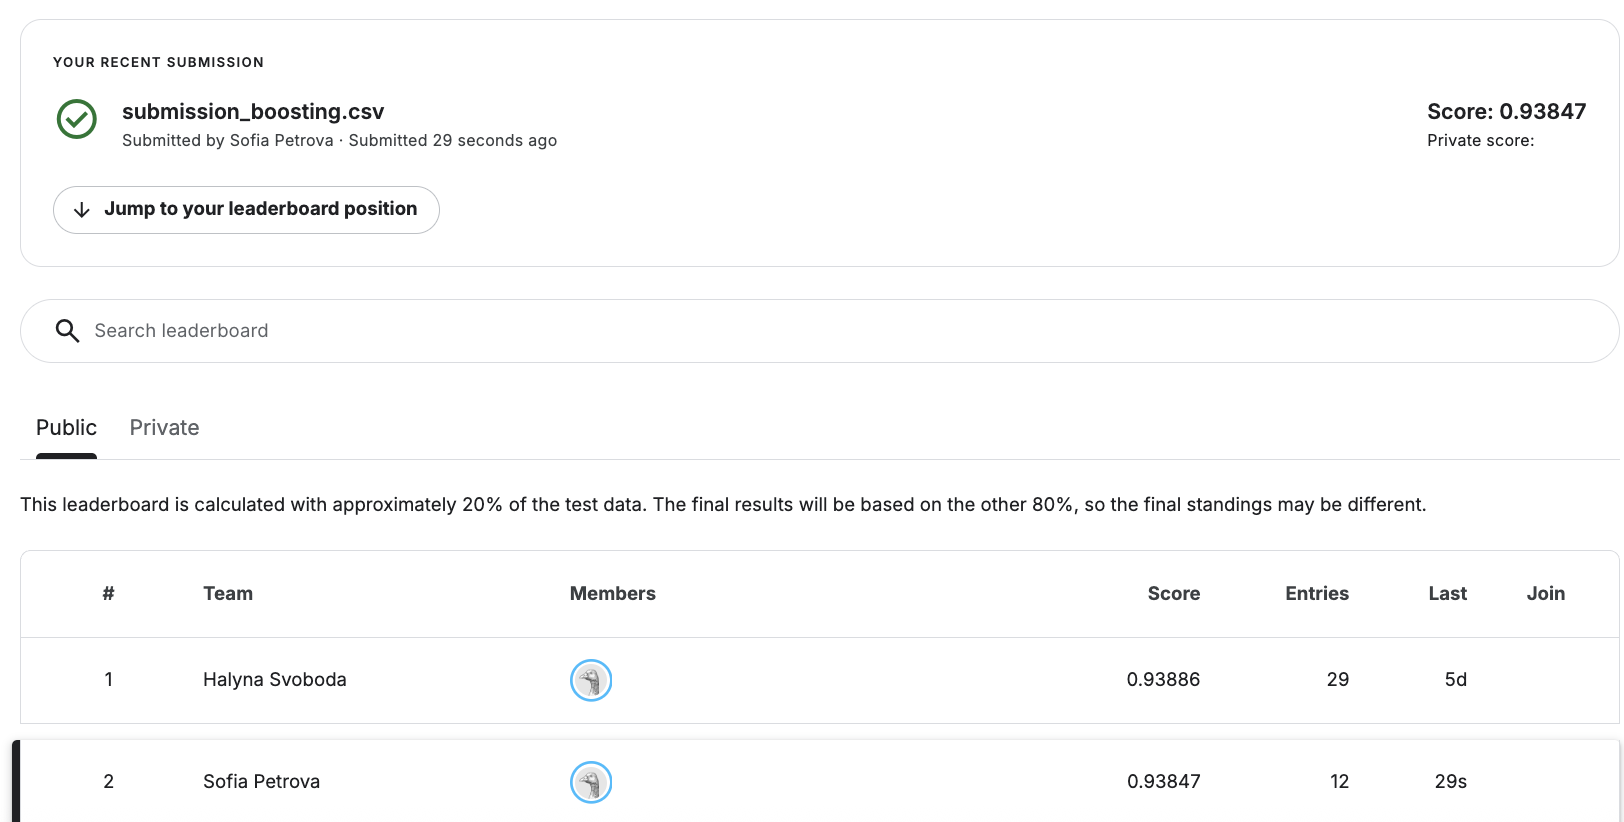